# Spherical Gaussian experiment: generative results

## Setup

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging
import corner
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("../../")

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


Using matplotlib backend: TkAgg


## Load results

In [2]:
algo_filenames = [
    "flow", "flow", "flow", "flow", 
    "pie", "pie", "pie", "pie", 
    "mf", "slice",
    "gamf", "gamf", "gamf", "gamf", "gamf",
    "hybrid",
    "mf_specified", "pie_specified"
]
algo_additionals = [
    "", "_long", "_long_shallow", "_long_deep",
    "", "_long", "_long_shallow", "_long_deep",
    "",
    "", 
    "", "_long_simple", "_long", "_long_shallow", "_long_deep",
    "", 
    "", ""
]
algo_labels = [
    "Flow (short)", "Flow (long)", "Flow (long, shallow)", "Flow (long, deep)",
    "PIE (short)", "PIE (long)", "PIE (long, shallow)", "PIE (long, deep)",
    "Manifold flow (short, simple)",
    "Slice (short, simple)",
    "GAMF (short, simple)", "GAMF (long, simple)", "GAMF (long)", "GAMF (long, shallow)", "GAMF (long, deep)",
    "Hybrid (short, simple)",
    "Specified MF (short)", "Specified PIE (short)"
]
algo_colors = ["C0"]*4 + ["C1"]*4 + ["C2", "C3"] + ["C4"]*5 + ["C6", "C7", "C8"]
algo_markers = ["o", "s", "^", "P"]*2 + ["o"]*2 + ["o", "s", "^", "P", "x"] + ["o", "*", "*"]

setup_filenames = [
    "2_3_0.010",
    "2_3_0.001",
    "2_3_0.100",
]
setup_labels = [
    r"2-sphere in 3 dim., $\epsilon = 0.01$",
    r"2-sphere in 3 dim., $\epsilon = 0.001$",
    r"2-sphere in 3 dim., $\epsilon = 0.1$",
]


In [3]:
result_dir = "../data/results"

x_gen = []
logp_gen = []
distance_gen = []

for algo_filename, algo_add in zip(algo_filenames, algo_additionals):
    x_gen_ = []
    logp_gen_ = []
    distance_gen_ = []
    for setup_filename in setup_filenames:
        try:
            x_gen_.append(np.load(
                "{}/{}_2_spherical_gaussian_{}{}_samples.npy".format(result_dir, algo_filename, setup_filename, algo_add)
            ))
        except FileNotFoundError as e:
            print(e)
            x_gen_.append(None)
            
        try:
            logp_gen_.append(np.load(
                "{}/{}_2_spherical_gaussian_{}{}_samples_likelihood.npy".format(result_dir, algo_filename, setup_filename, algo_add)
            ))
        except:
            logp_gen_.append(np.nan*np.ones(1000))
            
        try:
            distance_gen_.append(np.load(
                "{}/{}_2_spherical_gaussian_{}{}_samples_manifold_distance.npy".format(result_dir, algo_filename, setup_filename, algo_add)
            ))
        except:
            distance_gen_.append(np.nan*np.ones(1000))
            
    x_gen.append(x_gen_)
    logp_gen.append(logp_gen_)
    distance_gen.append(distance_gen_)
    
logp_gen = np.asarray(logp_gen)
distance_gen = np.asarray(distance_gen)


[Errno 2] No such file or directory: '../data/results/flow_2_spherical_gaussian_2_3_0.001_long_samples.npy'
[Errno 2] No such file or directory: '../data/results/flow_2_spherical_gaussian_2_3_0.100_long_samples.npy'
[Errno 2] No such file or directory: '../data/results/flow_2_spherical_gaussian_2_3_0.001_long_shallow_samples.npy'
[Errno 2] No such file or directory: '../data/results/flow_2_spherical_gaussian_2_3_0.100_long_shallow_samples.npy'
[Errno 2] No such file or directory: '../data/results/flow_2_spherical_gaussian_2_3_0.001_long_deep_samples.npy'
[Errno 2] No such file or directory: '../data/results/flow_2_spherical_gaussian_2_3_0.100_long_deep_samples.npy'
[Errno 2] No such file or directory: '../data/results/pie_2_spherical_gaussian_2_3_0.001_long_samples.npy'
[Errno 2] No such file or directory: '../data/results/pie_2_spherical_gaussian_2_3_0.100_long_samples.npy'
[Errno 2] No such file or directory: '../data/results/pie_2_spherical_gaussian_2_3_0.001_long_shallow_samples.np

In [4]:
min_logp = -100.
max_distance = 1.

mean_logp_gen = np.mean(np.clip(logp_gen, min_logp, None), axis=2)
mean_distance_gen = np.mean(np.clip(distance_gen, None, max_distance), axis=2)


In [5]:
mean_distance_gen

array([[7.70209569e-01, 8.16578918e-01, 5.80120851e-01],
       [8.09357886e-01,            nan,            nan],
       [6.95447749e-01,            nan,            nan],
       [7.65793012e-01,            nan,            nan],
       [1.59526020e-01, 5.58346291e-01, 1.83742423e-01],
       [9.97065205e-01,            nan,            nan],
       [9.96646314e-01,            nan,            nan],
       [9.82822291e-01,            nan,            nan],
       [6.32709537e-01, 7.34415988e-01, 9.24583904e-01],
       [9.54361269e-01, 8.39455690e-01, 4.82618643e-01],
       [8.36673869e-01, 8.11901422e-01, 6.60358573e-01],
       [9.61603627e-01,            nan,            nan],
       [           nan,            nan,            nan],
       [6.84578784e-01,            nan,            nan],
       [           nan,            nan,            nan],
       [5.58288225e-01, 9.41590491e-01, 3.66089176e-01],
       [1.46031380e-08, 1.43647194e-08, 1.49607658e-08],
       [1.47223473e-08,        

## Plot generated samples

In [6]:
def show_corner(algo=None, show=0, boundary=1.5):
    if algo is None:
        print("Simulator")
        x = np.load("../data/samples/spherical_gaussian/spherical_gaussian_2_3_0.010_x_test.npy")
        _ = corner.corner(x, range=[(-boundary, boundary) for _ in range(3)], bins=10)
        
    else:
        print(algo_labels[algo])
        _ = corner.corner(x_gen[algo][show], range=[(-boundary, boundary) for _ in range(3)], bins=10)

In [7]:
def show_scatter(algo=None, show=0, boundary=1.5):
    if algo is None:
        print("Simulator")
        x = np.load("../data/samples/spherical_gaussian/spherical_gaussian_2_3_0.010_x_test.npy")
    else:
        print(algo_labels[algo])
        x = x_gen[algo][show]
        
    fig = plt.figure(figsize=(5,5))
    ax = Axes3D(fig)
    ax.scatter(x[:,0], x[:,1], x[:,2])
    
    ax.set_xlim(-boundary, boundary)
    ax.set_ylim(-boundary, boundary)
    ax.set_zlim(-boundary, boundary)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.set_zlabel("$x_2$")
    
    plt.show()
    

In [8]:
show_scatter()

Simulator


PIE (short)


<IPython.core.display.Javascript object>


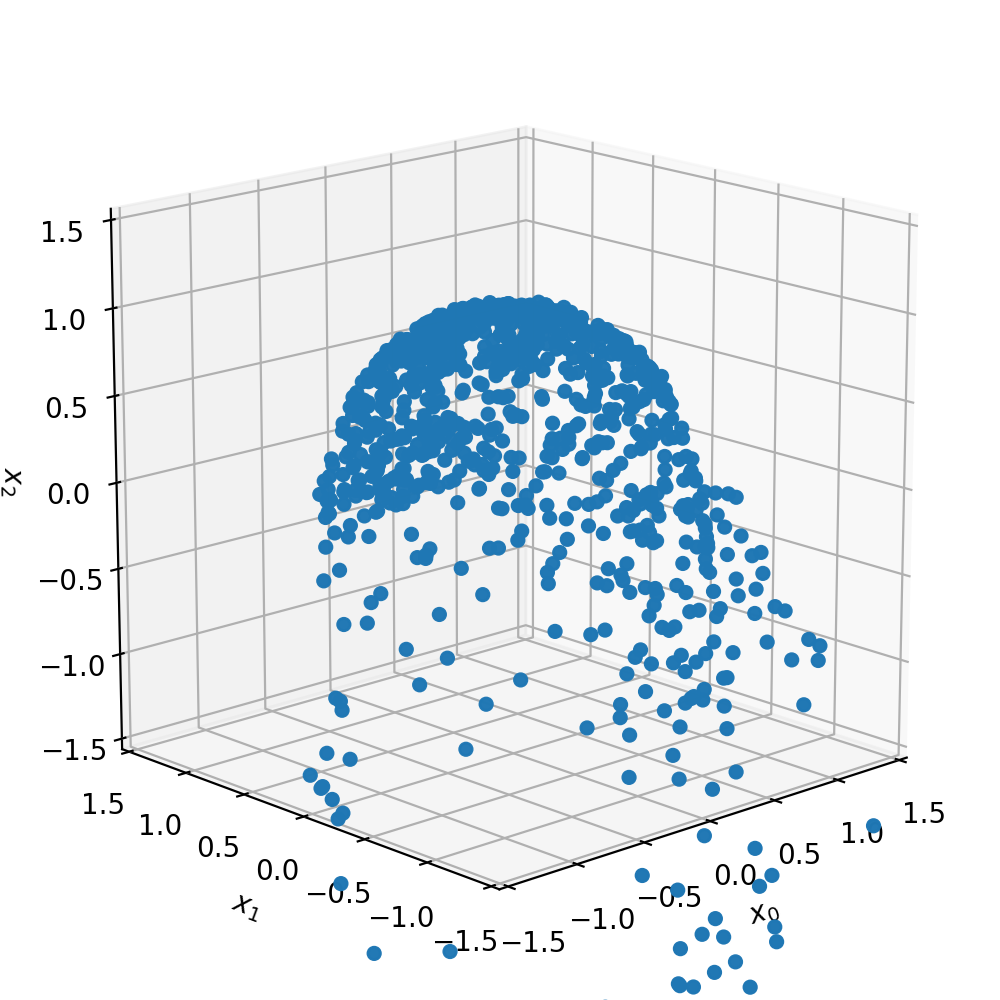

In [9]:
show_scatter(4)

Specified PIE (short)


<IPython.core.display.Javascript object>


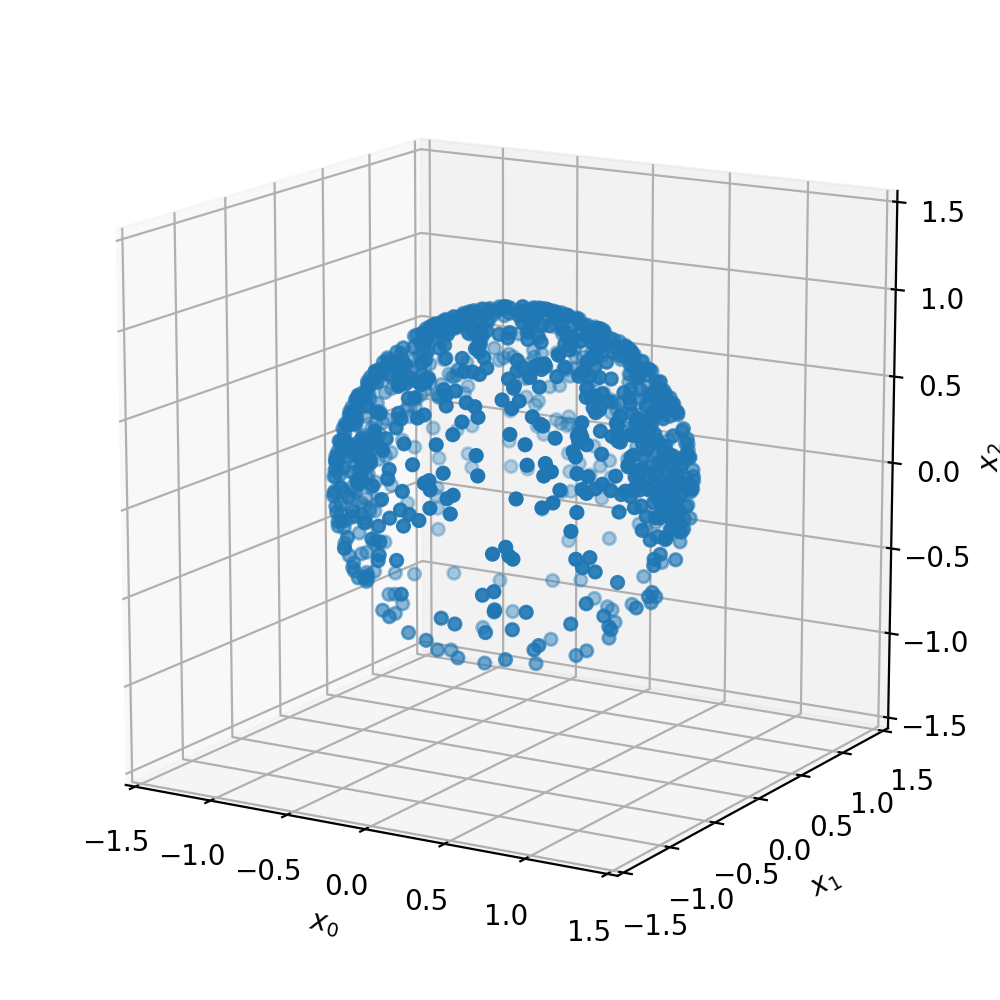

In [10]:
show_scatter(-1)

## Plot results

In [ ]:
show = [1,0,2]
ncols = 3
nrows = (len(show) - 1) // ncols + 1

xmin, xmax = 0.,1.

fig = plt.figure(figsize=(ncols*4, nrows*4))

for panel, setting in enumerate(show):
    ax = plt.subplot(nrows, ncols, panel + 1)
    
    plt.plot([], [], lw=0., ls=" ", label=setup_labels[setting])
    
    for algo, algo_label in enumerate(algo_labels):
        plt.hist(
            distance_gen[algo, setting,:],
            range=(xmin, xmax), bins=50,
            label=algo_label,
            histtype="step",
            lw=1.5
        )
        
    #plt.legend()

    plt.xlabel(r"Distance to manifold")
    plt.ylabel(r"Histogram")
    plt.xlim(xmin, xmax)
    plt.ylim(1.e-3, None)
    
plt.tight_layout()
plt.savefig("../figures/distance_distribution_spherical_gaussian.pdf")


In [ ]:
show = [1,0,2]
ncols = 3
nrows = (len(show) - 1) // ncols + 1

xmin, xmax = -100.,10.

fig = plt.figure(figsize=(ncols*4, nrows*4))

for panel, setting in enumerate(show):
    ax = plt.subplot(nrows, ncols, panel + 1)
    
    plt.plot([], [], lw=0., ls=" ", label=setup_labels[setting])
    
    for algo, algo_label in enumerate(algo_labels):
        plt.hist(
            logp_gen[algo, setting,:],
            range=(xmin, xmax), bins=50,
            label=algo_label,
            histtype="step",
            lw=1.5
        )
        
    #plt.legend()

    plt.xlabel(r"Log likelihood")
    plt.ylabel(r"Histogram")
    plt.xlim(xmin, xmax)
    plt.ylim(1.e-3, None)
    
plt.tight_layout()
plt.savefig("../figures/likelihood_distribution_spherical_gaussian.pdf")



In [ ]:
show = [1, 0, 2]
xs = [0.001, 0.01, 0.1]

fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,3,1)
for mean_logp_gen_, algo_label, c, algo_marker in zip(mean_logp_gen, algo_labels, algo_colors, algo_markers):
    print(algo_label, mean_logp_gen_[show])
    plt.plot(xs, mean_logp_gen_[show], label=algo_label, ls="-", marker=algo_marker, ms=8., c=c)
# plt.legend()
plt.xscale("log")
plt.xlabel("Manifold fuzziness (width)")
plt.ylabel("Mean true log likelihood of samples generated from flow")

ax = plt.subplot(1,3,2)
for mean_distance_gen_, algo_label, c, algo_marker in zip(mean_distance_gen, algo_labels, algo_colors, algo_markers):
    plt.plot(xs, mean_distance_gen_[show], label=algo_label, ls="-", marker=algo_marker, ms=8, c=c)
#plt.legend()
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Manifold fuzziness (width)")
plt.ylabel("Mean distance to manifold of samples generated from flow")

ax = plt.subplot(1,3,3)
plt.legend()
for mean_logp_gen_, algo_label, c, algo_marker in zip(mean_logp_gen, algo_labels, algo_colors, algo_markers):
    plt.plot([], [], label=algo_label, ls="-", marker=algo_marker, ms=8., c=c)
plt.legend(loc="center left")
plt.axis("off")

plt.tight_layout()
plt.savefig("../figures/distance_likelihood_vs_epsilon_spherical_gaussian.pdf")
